In [1]:
def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="conv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d(inputconv, o_d, f_w, s_w, padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv

def general_deconv2d(inputconv, outshape, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="deconv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d_transpose(inputconv, o_d, [f_h, f_w], [s_h, s_w], padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv
    
def build_resnet_block(inputres, dim, name="resnet"):
    with tf.variable_scope(name):
        out_res = tf.pad(inputres, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c2",do_relu=False)
        return tf.nn.relu(out_res + inputres)
    

In [2]:
def generator(inputgen, name="generator"):
    with tf.variable_scope(name):
        f = 7
        ks = 3
        ngf = 64

        pad_input = tf.pad(inputgen,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c1 = general_conv2d(pad_input, ngf, f, f, 1, 1, 0.02,name="c1")
        o_c2 = general_conv2d(o_c1, ngf*2, ks, ks, 2, 2, 0.02,"SAME","c2")
        o_c3 = general_conv2d(o_c2, ngf*4, ks, ks, 2, 2, 0.02,"SAME","c3")

        o_r1 = build_resnet_block(o_c3, ngf*4, "r1")
        o_r2 = build_resnet_block(o_r1, ngf*4, "r2")
        o_r3 = build_resnet_block(o_r2, ngf*4, "r3")
        o_r4 = build_resnet_block(o_r3, ngf*4, "r4")
        o_r5 = build_resnet_block(o_r4, ngf*4, "r5")
        o_r6 = build_resnet_block(o_r5, ngf*4, "r6")

        o_c4 = general_deconv2d(o_r6, [1,64,64,ngf*2], ngf*2, ks, ks, 2, 2, 0.02,"SAME","c4")
        o_c5 = general_deconv2d(o_c4, [1,128,128,ngf], ngf, ks, ks, 2, 2, 0.02,"SAME","c5")
        o_c5_pad = tf.pad(o_c5,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c6 = general_conv2d(o_c5_pad, 3, f, f, 1, 1, 0.02,"VALID","c6",do_relu=False)

        # Adding the tanh layer

        out_gen = tf.nn.tanh(o_c6,"t1")


        return out_gen

In [3]:
def discriminator(inputdisc, name="discriminator"):
    with tf.variable_scope(name):
        f = 4
        ndf = 64

        o_c1 = general_conv2d(inputdisc, ndf, f, f, 2, 2, 0.02, "SAME", "c1", do_norm=False, relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf*2, f, f, 2, 2, 0.02, "SAME", "c2", relufactor=0.2)
        o_c3 = general_conv2d(o_c2, ndf*4, f, f, 2, 2, 0.02, "SAME", "c3", relufactor=0.2)
        o_c4 = general_conv2d(o_c3, ndf*8, f, f, 1, 1, 0.02, "SAME", "c4",relufactor=0.2)
        o_c5 = general_conv2d(o_c4, 1, f, f, 1, 1, 0.02, "SAME", "c5",do_norm=False,do_relu=False)

        return o_c5

In [4]:
def gen_image_pool(num_gens, genimg, gen_pool):
    ''' This function saves the generated image to corresponding pool of images.
    In starting. It keeps on feeling the pool till it is full and then randomly selects an
    already stored image and replace it with new one.'''
    pool_size = 50
    if(num_gens < pool_size):
        gen_pool[num_gens] = genimg
        return genimg
    else :
        p = random.random()
        if p > 0.5:
            random_id = random.randint(0,pool_size-1)
            temp = gen_pool[random_id]
            gen_pool[random_id] = genimg
            return temp
        else :
            return genimg

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import random

train_a_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainA/*.jpg")    
train_b_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainB/*.jpg")    


train_a_queue = tf.train.string_input_producer(train_a_files)
train_b_queue = tf.train.string_input_producer(train_b_files)


image_reader = tf.WholeFileReader()
_, image_a = image_reader.read(train_a_queue)
_, image_b = image_reader.read(train_b_queue)

image_A = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_a),[256,256]),127.5),1)
image_B = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_b),[256,256]),127.5),1)


input_A = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_A")
input_B = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_B")

gen_A_pool = tf.placeholder(tf.float32, [None, 256, 256, 3], name="gen_A_pool")
gen_B_pool = tf.placeholder(tf.float32, [None, 256, 256, 3], name="gen_B_pool")

with tf.variable_scope("Model") as scope:
    gena = generator(input_B, name="g_A")
    genb = generator(input_A, name="g_B")
    dica = discriminator(input_A, name="d_A")
    dicb = discriminator(input_B, name="d_B")
    
    scope.reuse_variables()
    
    cyca = generator(genb, name="g_A")
    cycb = generator(gena, name="g_B")
    dic_gana = discriminator(gena, name="d_A")
    dic_ganb = discriminator(genb, name="d_B")
    
    scope.reuse_variables()

    dic_gen_A_pool = discriminator(gen_A_pool, "d_A")
    dic_gen_B_pool = discriminator(gen_B_pool, "d_B")

d_loss_a = (tf.reduce_mean(tf.squared_difference(dica, 1)) + tf.reduce_mean(tf.square(dic_gen_A_pool)))/2
d_loss_b = (tf.reduce_mean(tf.squared_difference(dicb, 1)) + tf.reduce_mean(tf.square(dic_gen_B_pool)))/2

cyc_loss = tf.reduce_mean(tf.abs(input_A-cyca)) + tf.reduce_mean(tf.abs(input_B-cycb))

g_loss_a = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_gen_A_pool, 1))
g_loss_b = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_gen_B_pool, 1))

optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5)

model_vars = tf.trainable_variables()
d_A_vars = [var for var in model_vars if 'd_A' in var.name]
g_A_vars = [var for var in model_vars if 'g_A' in var.name]
d_B_vars = [var for var in model_vars if 'd_B' in var.name]
g_B_vars = [var for var in model_vars if 'g_B' in var.name]

d_A_trainer = optimizer.minimize(d_loss_a, var_list=d_A_vars)
d_B_trainer = optimizer.minimize(d_loss_b, var_list=d_B_vars)
g_A_trainer = optimizer.minimize(g_loss_a, var_list=g_A_vars)
g_B_trainer = optimizer.minimize(g_loss_b, var_list=g_B_vars)

#for var in model_vars: print(var.name)

with tf.control_dependencies([g_A_trainer, d_B_trainer, g_B_trainer, d_A_trainer]):
      optimizers = tf.no_op(name='optimizers')

epoch:0 idx:0 g_A_trainer:9.261240 d_B_trainer:0.498205 g_B_trainer:9.261238 d_A_trainer0.499953


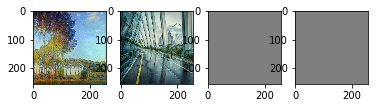

epoch:0 idx:1 g_A_trainer:9.322008 d_B_trainer:0.408548 g_B_trainer:9.317905 d_A_trainer0.453615


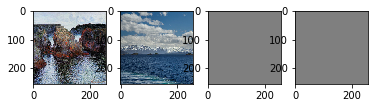

epoch:0 idx:2 g_A_trainer:9.044302 d_B_trainer:0.223177 g_B_trainer:9.023298 d_A_trainer0.329388


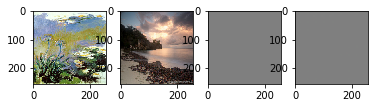

epoch:0 idx:3 g_A_trainer:8.597727 d_B_trainer:0.108939 g_B_trainer:8.521263 d_A_trainer0.098753


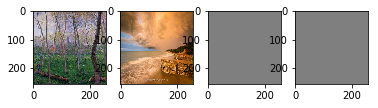

epoch:0 idx:4 g_A_trainer:10.285316 d_B_trainer:0.115404 g_B_trainer:10.563934 d_A_trainer2.245574


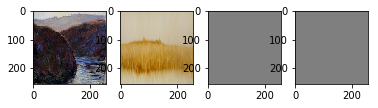

epoch:0 idx:5 g_A_trainer:7.778984 d_B_trainer:0.046394 g_B_trainer:7.775163 d_A_trainer0.140250


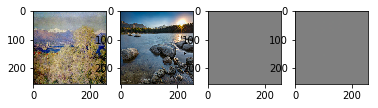

epoch:0 idx:6 g_A_trainer:9.307230 d_B_trainer:0.081703 g_B_trainer:9.266009 d_A_trainer0.253230


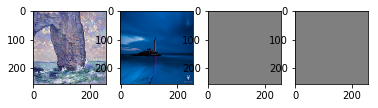

epoch:0 idx:7 g_A_trainer:9.533937 d_B_trainer:0.262287 g_B_trainer:9.533242 d_A_trainer0.280365


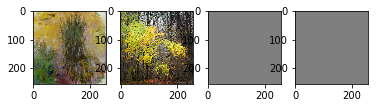

epoch:0 idx:8 g_A_trainer:9.244750 d_B_trainer:0.152205 g_B_trainer:9.235250 d_A_trainer0.219675


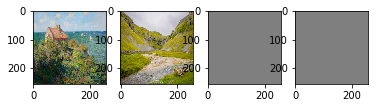

epoch:0 idx:9 g_A_trainer:8.764163 d_B_trainer:0.114127 g_B_trainer:8.719373 d_A_trainer0.172412


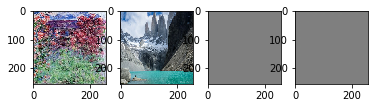

epoch:0 idx:10 g_A_trainer:9.949259 d_B_trainer:0.087415 g_B_trainer:9.916135 d_A_trainer0.323798


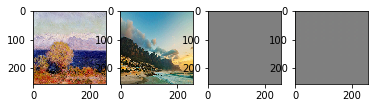

epoch:0 idx:11 g_A_trainer:8.373076 d_B_trainer:0.044914 g_B_trainer:8.336464 d_A_trainer0.196054


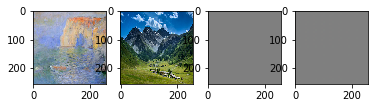

epoch:0 idx:12 g_A_trainer:8.564825 d_B_trainer:0.063820 g_B_trainer:8.515341 d_A_trainer0.162544


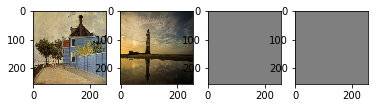

epoch:0 idx:13 g_A_trainer:9.532082 d_B_trainer:0.064574 g_B_trainer:9.523409 d_A_trainer0.081347


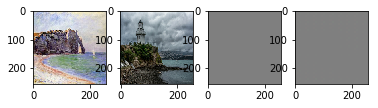

epoch:0 idx:14 g_A_trainer:11.433006 d_B_trainer:0.109701 g_B_trainer:11.461379 d_A_trainer0.142255


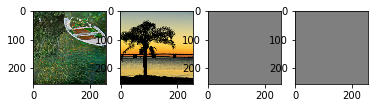

epoch:0 idx:15 g_A_trainer:10.274191 d_B_trainer:0.264565 g_B_trainer:10.325593 d_A_trainer0.080754


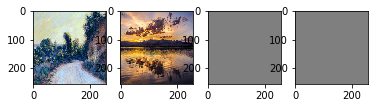

epoch:0 idx:16 g_A_trainer:9.291197 d_B_trainer:0.230387 g_B_trainer:9.317849 d_A_trainer0.103370


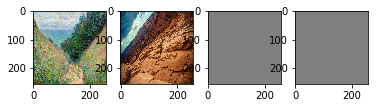

epoch:0 idx:17 g_A_trainer:10.389159 d_B_trainer:0.106843 g_B_trainer:10.385977 d_A_trainer0.052516


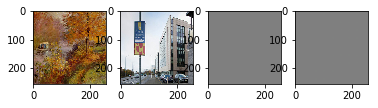

epoch:0 idx:18 g_A_trainer:9.818262 d_B_trainer:0.113892 g_B_trainer:9.830205 d_A_trainer0.042267


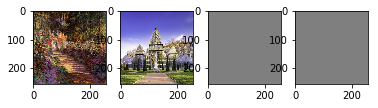

epoch:0 idx:19 g_A_trainer:8.543259 d_B_trainer:0.047012 g_B_trainer:8.521551 d_A_trainer0.071648


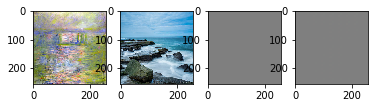

epoch:0 idx:20 g_A_trainer:8.974689 d_B_trainer:0.088865 g_B_trainer:8.962606 d_A_trainer0.050435


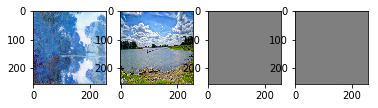

epoch:0 idx:21 g_A_trainer:14.346169 d_B_trainer:0.623926 g_B_trainer:14.297734 d_A_trainer0.058542


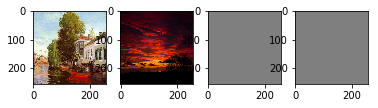

epoch:0 idx:22 g_A_trainer:9.366857 d_B_trainer:0.313312 g_B_trainer:9.404639 d_A_trainer0.036927


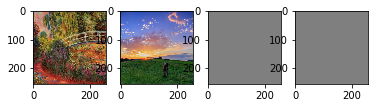

epoch:0 idx:23 g_A_trainer:11.301161 d_B_trainer:0.382667 g_B_trainer:11.347589 d_A_trainer0.044022


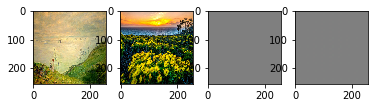

epoch:0 idx:24 g_A_trainer:9.487509 d_B_trainer:0.340734 g_B_trainer:9.529118 d_A_trainer0.096955


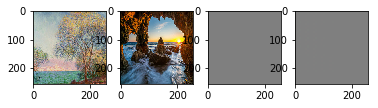

epoch:0 idx:25 g_A_trainer:10.481320 d_B_trainer:0.264576 g_B_trainer:10.513770 d_A_trainer0.069488


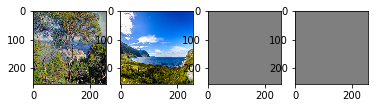

epoch:0 idx:26 g_A_trainer:11.459917 d_B_trainer:0.219904 g_B_trainer:11.505919 d_A_trainer0.026855


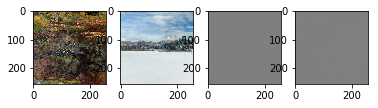

epoch:0 idx:27 g_A_trainer:11.258361 d_B_trainer:0.362553 g_B_trainer:11.283639 d_A_trainer0.050965


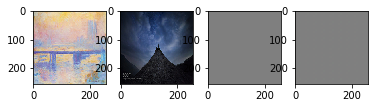

epoch:0 idx:28 g_A_trainer:7.841012 d_B_trainer:0.235168 g_B_trainer:7.819314 d_A_trainer0.102405


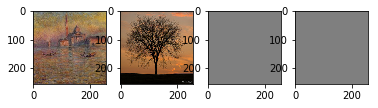

epoch:0 idx:29 g_A_trainer:6.672231 d_B_trainer:0.132489 g_B_trainer:6.597095 d_A_trainer0.194142


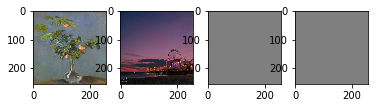

epoch:0 idx:30 g_A_trainer:10.469717 d_B_trainer:0.443468 g_B_trainer:10.339809 d_A_trainer0.055779


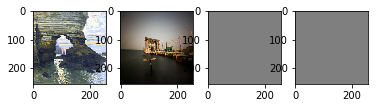

epoch:0 idx:31 g_A_trainer:9.264988 d_B_trainer:0.095946 g_B_trainer:9.273320 d_A_trainer0.055255


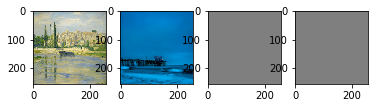

epoch:0 idx:32 g_A_trainer:11.682048 d_B_trainer:0.123398 g_B_trainer:11.704521 d_A_trainer0.079461


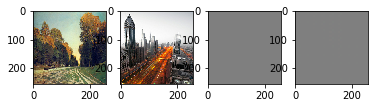

epoch:0 idx:33 g_A_trainer:8.531739 d_B_trainer:0.229017 g_B_trainer:8.510221 d_A_trainer0.079314


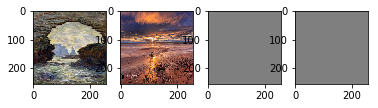

epoch:0 idx:34 g_A_trainer:5.289073 d_B_trainer:0.181409 g_B_trainer:5.244966 d_A_trainer0.139598


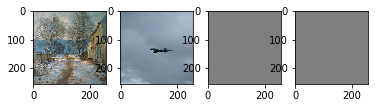

epoch:0 idx:35 g_A_trainer:9.428602 d_B_trainer:0.064800 g_B_trainer:9.371127 d_A_trainer0.033367


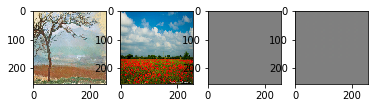

epoch:0 idx:36 g_A_trainer:9.415489 d_B_trainer:0.079483 g_B_trainer:9.369188 d_A_trainer0.062225


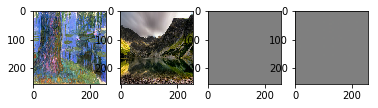

epoch:0 idx:37 g_A_trainer:9.476951 d_B_trainer:0.072434 g_B_trainer:9.363363 d_A_trainer0.055251


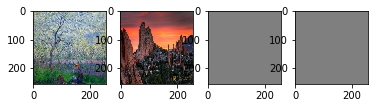

epoch:0 idx:38 g_A_trainer:9.667005 d_B_trainer:0.104943 g_B_trainer:9.568874 d_A_trainer0.083115


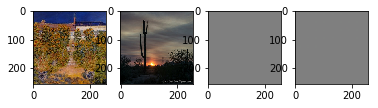

epoch:0 idx:39 g_A_trainer:10.511333 d_B_trainer:0.076416 g_B_trainer:10.368551 d_A_trainer0.053046


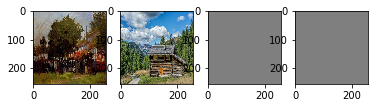

epoch:0 idx:40 g_A_trainer:8.748494 d_B_trainer:0.101305 g_B_trainer:8.639299 d_A_trainer0.093394


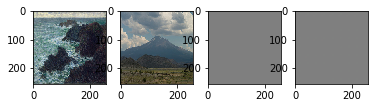

epoch:0 idx:41 g_A_trainer:10.434933 d_B_trainer:0.078109 g_B_trainer:10.334150 d_A_trainer0.041030


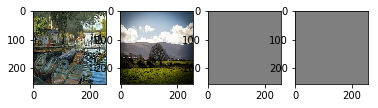

epoch:0 idx:42 g_A_trainer:8.657789 d_B_trainer:0.109328 g_B_trainer:8.613146 d_A_trainer0.087285


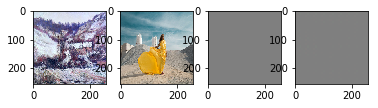

epoch:0 idx:43 g_A_trainer:12.063640 d_B_trainer:0.032453 g_B_trainer:11.984065 d_A_trainer0.030897


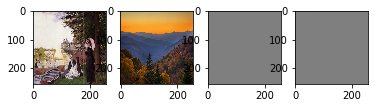

epoch:0 idx:44 g_A_trainer:9.123506 d_B_trainer:0.056836 g_B_trainer:9.016997 d_A_trainer0.029864


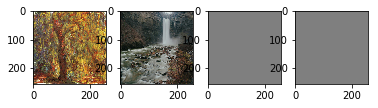

epoch:0 idx:45 g_A_trainer:10.024734 d_B_trainer:0.113070 g_B_trainer:9.891418 d_A_trainer0.039957


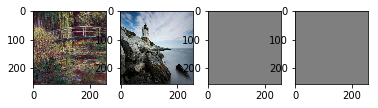

epoch:0 idx:46 g_A_trainer:10.032091 d_B_trainer:0.048685 g_B_trainer:9.964259 d_A_trainer0.068096


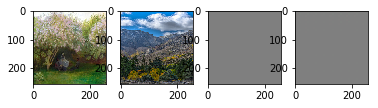

epoch:0 idx:47 g_A_trainer:10.572672 d_B_trainer:0.064139 g_B_trainer:10.506528 d_A_trainer0.060871


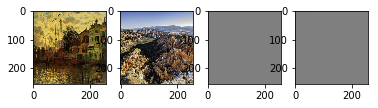

epoch:0 idx:48 g_A_trainer:7.999507 d_B_trainer:0.044313 g_B_trainer:7.893957 d_A_trainer0.080710


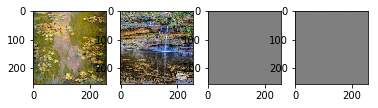

epoch:0 idx:49 g_A_trainer:11.903805 d_B_trainer:0.204249 g_B_trainer:11.776234 d_A_trainer0.067322


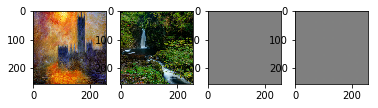

epoch:0 idx:50 g_A_trainer:9.443930 d_B_trainer:0.134875 g_B_trainer:9.410495 d_A_trainer0.062796


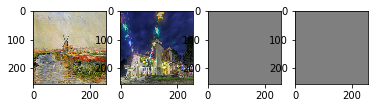

epoch:0 idx:51 g_A_trainer:9.233627 d_B_trainer:0.107118 g_B_trainer:9.241126 d_A_trainer0.029247


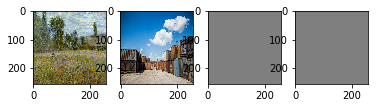

epoch:0 idx:52 g_A_trainer:9.297650 d_B_trainer:0.113057 g_B_trainer:9.292942 d_A_trainer0.039679


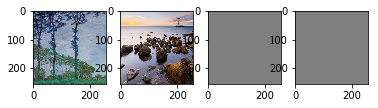

epoch:0 idx:53 g_A_trainer:10.579168 d_B_trainer:0.088335 g_B_trainer:10.565513 d_A_trainer0.268978


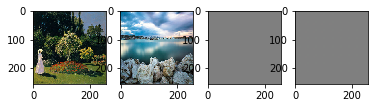

epoch:0 idx:54 g_A_trainer:13.133495 d_B_trainer:0.031085 g_B_trainer:13.033489 d_A_trainer0.152423


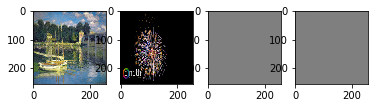

epoch:0 idx:55 g_A_trainer:8.716349 d_B_trainer:0.061125 g_B_trainer:8.594170 d_A_trainer0.132076


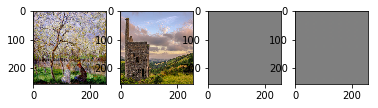

epoch:0 idx:56 g_A_trainer:11.512891 d_B_trainer:0.103191 g_B_trainer:11.400580 d_A_trainer0.158475


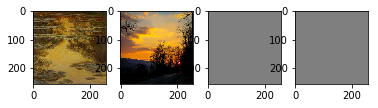

epoch:0 idx:57 g_A_trainer:6.991570 d_B_trainer:0.040001 g_B_trainer:6.951859 d_A_trainer0.128570


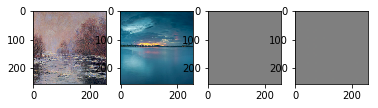

epoch:0 idx:58 g_A_trainer:9.555927 d_B_trainer:0.157356 g_B_trainer:9.575486 d_A_trainer0.444578


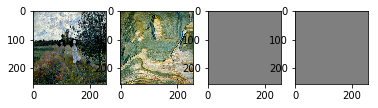

epoch:0 idx:59 g_A_trainer:8.084869 d_B_trainer:0.116702 g_B_trainer:8.012722 d_A_trainer0.136155


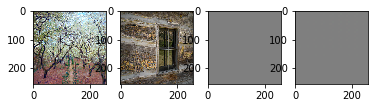

epoch:0 idx:60 g_A_trainer:10.056810 d_B_trainer:0.157232 g_B_trainer:9.928268 d_A_trainer0.209660


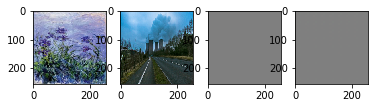

epoch:0 idx:61 g_A_trainer:9.769355 d_B_trainer:0.059425 g_B_trainer:9.728884 d_A_trainer0.138255


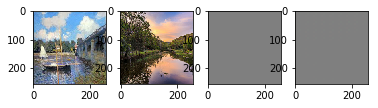

In [ ]:
gena_pool = np.zeros((50, 1, 256, 256, 3))
genb_pool = np.zeros((50, 1, 256, 256, 3))

A_input = np.zeros((100, 1, 256, 256, 3))
B_input = np.zeros((100, 1, 256, 256, 3))

with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    # Loading images into the tensors
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for idx in range(0, 100):
        imga = sess.run(image_A).reshape((1, 256, 256, 3))
        imgb = sess.run(image_B).reshape((1, 256, 256, 3))
        A_input[idx] = imga
        B_input[idx] = imgb
    coord.request_stop()
    coord.join(threads)
    
    num_gen_inputs = 0
    
    for epoch in range(0,101):
        for idx in range(0, 100):
            imggenb, imggena = sess.run([genb, gena],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            
            # train
            _, a, b, c, d = (
                  sess.run(
                      [optimizers, g_loss_a, d_loss_b, g_loss_b, d_loss_a],
                      feed_dict={input_A:A_input[idx], input_B:B_input[idx],
                                 gen_A_pool: gen_image_pool(num_gen_inputs, imggena, gena_pool),
                                 gen_B_pool: gen_image_pool(num_gen_inputs, imggenb, genb_pool)}
                  )
            )
            num_gen_inputs += 1
            # Optimizing the G_A network
            #_, a, imggena, imggenb = sess.run([g_A_trainer, g_loss_a, genb, gena],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            #_, b = sess.run([d_B_trainer, d_loss_b],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            #_, c = sess.run([g_B_trainer, g_loss_b],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            #_, d = sess.run([d_A_trainer, d_loss_a],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})

            print("epoch:%d idx:%d g_A_trainer:%f d_B_trainer:%f g_B_trainer:%f d_A_trainer%f"%(epoch, idx, a, b, c, d))
            plt.subplot(141); plt.imshow(((A_input[idx].reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(142); plt.imshow(((B_input[idx].reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(143); plt.imshow(((imggena.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(144); plt.imshow(((imggenb.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.show()